In [1]:
import os
import shutil


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import h5py
import tensorflow as tf

from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("OpenCV:", cv2.__version__)
print("h5py:", h5py.__version__)
print("Scikit-learn:", sklearn.__version__)


TensorFlow: 2.13.1
NumPy: 1.24.3
OpenCV: 4.8.1
h5py: 3.10.0
Scikit-learn: 1.3.2


In [2]:

BASE_DIR = os.getcwd()

SOURCE_DIR = os.path.join(BASE_DIR, "Dataset")         
TARGET_DIR = os.path.join(BASE_DIR, "Dataset_5Class")  


In [3]:
CLASS_MAPPING = {
    "Non_Demented": "CN",
    "Mild_Demented": "MCI",
    "Very_Mild_Demented": "MCI",
    "Moderate_Demented": "AD"
}


In [4]:
for cls in ["CN", "MCI", "AD"]:
    os.makedirs(os.path.join(TARGET_DIR, cls), exist_ok=True)


In [6]:
import os
import shutil

VALID_EXTENSIONS = (".jpg", ".jpeg", ".png")

for src_class, tgt_class in CLASS_MAPPING.items():
    src_path = os.path.join(SOURCE_DIR, src_class)
    tgt_path = os.path.join(TARGET_DIR, tgt_class)

    for img_name in os.listdir(src_path):
        src_img = os.path.join(src_path, img_name)

        if not os.path.isfile(src_img):
            continue
        if not img_name.lower().endswith(VALID_EXTENSIONS):
            continue

        tgt_img = os.path.join(tgt_path, f"{src_class}_{img_name}")
        shutil.copy2(src_img, tgt_img)  # copy2 preserves metadata

print("✅ Dataset successfully converted to 3-class format")


✅ Dataset successfully converted to 3-class format


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
IMG_SIZE = 224          # Required for VGG, ResNet, EfficientNet
BATCH_SIZE = 32
SEED = 42

DATA_DIR = "Dataset_5Class"


In [4]:
def preprocess_mri(img_path):
    # Load MRI as grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Resize to CNN input size
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Gaussian noise reduction
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Normalize intensities
    img = img / 255.0

    # Convert to 3-channel (for pretrained CNNs)
    img = np.stack([img]*3, axis=-1)

    return img


In [5]:
classes = ["CN", "MCI", "AD"]
data = []
labels = []
import os
for idx, cls in enumerate(classes):
    cls_path = os.path.join(DATA_DIR, cls)
    for img_name in os.listdir(cls_path):
        try:
            img_path = os.path.join(cls_path, img_name)
            img = preprocess_mri(img_path)
            data.append(img)
            labels.append(idx)
        except:
            continue

X = np.array(data)
y = np.array(labels)

print("Dataset loaded:")
print("X shape:", X.shape)
print("y shape:", y.shape)


Dataset loaded:
X shape: (4309, 224, 224, 3)
y shape: (4309,)


In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=SEED,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=SEED,
    stratify=y_temp
)


In [6]:
train_gen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator()


In [9]:
train_data = train_gen.flow(
    X_train,
    tf.keras.utils.to_categorical(y_train),
    batch_size=BATCH_SIZE,
    seed=SEED
)

val_data = val_test_gen.flow(
    X_val,
    tf.keras.utils.to_categorical(y_val),
    batch_size=BATCH_SIZE,
    seed=SEED
)

test_data = val_test_gen.flow(
    X_test,
    tf.keras.utils.to_categorical(y_test),
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [10]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.8287991206375378, 1: 0.571861964353432, 2: 22.340740740740742}


In [11]:
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


In [12]:
def add_classification_head(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(3, activation="softmax")(x)
    return output


In [13]:
def build_vgg16_model():
    base_model = VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False  # freeze backbone

    output = add_classification_head(base_model)
    model = Model(inputs=base_model.input, outputs=output)
    return model


In [14]:
def build_resnet50_model():
    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    output = add_classification_head(base_model)
    model = Model(inputs=base_model.input, outputs=output)
    return model


In [15]:
def build_efficientnet_model():
    base_model = EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    output = add_classification_head(base_model)
    model = Model(inputs=base_model.input, outputs=output)
    return model


In [16]:
vgg16_model = build_vgg16_model()
resnet50_model = build_resnet50_model()
efficientnet_model = build_efficientnet_model()


In [17]:
optimizer = Adam(learning_rate=1e-4)

for model in [vgg16_model, resnet50_model, efficientnet_model]:
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )


In [18]:
history_vgg = vgg16_model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights
)

Epoch 1/15
95/95 [==============================] - 285s 3s/step - loss: 1.2019 - accuracy: 0.4048 - val_loss: 1.0759 - val_accuracy: 0.4427
Epoch 2/15
95/95 [==============================] - 296s 3s/step - loss: 1.1344 - accuracy: 0.3654 - val_loss: 1.0794 - val_accuracy: 0.4551
Epoch 3/15
95/95 [==============================] - 287s 3s/step - loss: 1.1501 - accuracy: 0.3657 - val_loss: 1.1352 - val_accuracy: 0.1734
Epoch 4/15
95/95 [==============================] - 273s 3s/step - loss: 1.0865 - accuracy: 0.3428 - val_loss: 0.9885 - val_accuracy: 0.5867
Epoch 5/15
95/95 [==============================] - 272s 3s/step - loss: 1.0674 - accuracy: 0.3601 - val_loss: 1.0002 - val_accuracy: 0.6734
Epoch 6/15
95/95 [==============================] - 271s 3s/step - loss: 1.0565 - accuracy: 0.4214 - val_loss: 1.0484 - val_accuracy: 0.4861
Epoch 7/15
95/95 [==============================] - 279s 3s/step - loss: 1.0465 - accuracy: 0.4440 - val_loss: 1.0413 - val_accuracy: 0.4938
Epoch 8/15
95

In [20]:
import os
os.makedirs("saved_models", exist_ok=True)

vgg16_model.save("saved_models/vgg16_trained.keras")


In [22]:
from tensorflow.keras.optimizers import Adam

resnet50_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [23]:
history_resnet = resnet50_model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights
)


Epoch 1/15
95/95 [==============================] - 142s 1s/step - loss: 1.3201 - accuracy: 0.3309 - val_loss: 1.0262 - val_accuracy: 0.5851
Epoch 2/15
95/95 [==============================] - 142s 1s/step - loss: 1.2291 - accuracy: 0.3382 - val_loss: 0.9527 - val_accuracy: 0.5944
Epoch 3/15
95/95 [==============================] - 142s 1s/step - loss: 1.1644 - accuracy: 0.3518 - val_loss: 0.9932 - val_accuracy: 0.4938
Epoch 4/15
95/95 [==============================] - 142s 1s/step - loss: 1.1092 - accuracy: 0.3700 - val_loss: 1.1004 - val_accuracy: 0.2972
Epoch 5/15
95/95 [==============================] - 148s 2s/step - loss: 1.0911 - accuracy: 0.4009 - val_loss: 1.0937 - val_accuracy: 0.2663
Epoch 6/15
95/95 [==============================] - 143s 2s/step - loss: 1.0619 - accuracy: 0.3853 - val_loss: 1.2091 - val_accuracy: 0.1533
Epoch 7/15
95/95 [==============================] - 144s 2s/step - loss: 1.0371 - accuracy: 0.3485 - val_loss: 0.9806 - val_accuracy: 0.5418
Epoch 8/15
95

In [24]:
resnet50_model.save("saved_models/resnet50_trained.keras")

In [25]:
efficientnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [26]:
history_eff = efficientnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights
)

Epoch 1/15
95/95 [==============================] - 89s 884ms/step - loss: 1.1234 - accuracy: 0.3906 - val_loss: 1.2184 - val_accuracy: 0.0139
Epoch 2/15
95/95 [==============================] - 80s 844ms/step - loss: 1.1120 - accuracy: 0.2828 - val_loss: 0.9895 - val_accuracy: 0.4025
Epoch 3/15
95/95 [==============================] - 80s 844ms/step - loss: 1.1347 - accuracy: 0.3130 - val_loss: 1.0473 - val_accuracy: 0.5836
Epoch 4/15
95/95 [==============================] - 80s 845ms/step - loss: 1.1099 - accuracy: 0.3541 - val_loss: 1.0607 - val_accuracy: 0.5836
Epoch 5/15
95/95 [==============================] - 81s 848ms/step - loss: 1.1176 - accuracy: 0.3903 - val_loss: 1.1443 - val_accuracy: 0.0139
Epoch 6/15
95/95 [==============================] - 81s 852ms/step - loss: 1.1158 - accuracy: 0.2454 - val_loss: 1.0900 - val_accuracy: 0.5836
Epoch 7/15
95/95 [==============================] - 81s 854ms/step - loss: 1.1066 - accuracy: 0.4198 - val_loss: 1.1092 - val_accuracy: 0.0139

In [27]:
efficientnet_model.save("saved_models/efficientnet_trained.keras")

In [28]:
eff_class_weights = {
    0: class_weights[0],
    1: class_weights[1],
    2: class_weights[2] / 5   # reduce AD dominance
}


In [29]:
history_eff = efficientnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=eff_class_weights
)


Epoch 1/15
95/95 [==============================] - 93s 967ms/step - loss: 0.7933 - accuracy: 0.3017 - val_loss: 1.0068 - val_accuracy: 0.4025
Epoch 2/15
95/95 [==============================] - 81s 853ms/step - loss: 0.7281 - accuracy: 0.4599 - val_loss: 0.8919 - val_accuracy: 0.4025
Epoch 3/15
95/95 [==============================] - 80s 846ms/step - loss: 0.7137 - accuracy: 0.4712 - val_loss: 0.8497 - val_accuracy: 0.5836
Epoch 4/15
95/95 [==============================] - 81s 850ms/step - loss: 0.7086 - accuracy: 0.5033 - val_loss: 0.8433 - val_accuracy: 0.4025
Epoch 5/15
95/95 [==============================] - 80s 846ms/step - loss: 0.6958 - accuracy: 0.5123 - val_loss: 0.8227 - val_accuracy: 0.5836
Epoch 6/15
95/95 [==============================] - 80s 842ms/step - loss: 0.7070 - accuracy: 0.4804 - val_loss: 0.8123 - val_accuracy: 0.5836
Epoch 7/15
95/95 [==============================] - 80s 846ms/step - loss: 0.6965 - accuracy: 0.5060 - val_loss: 0.8135 - val_accuracy: 0.5836

In [30]:
efficientnet_model.save("saved_models/efficientnet_trained.keras")

In [31]:
pred_vgg = vgg16_model.predict(test_data)
pred_resnet = resnet50_model.predict(test_data)
pred_eff = efficientnet_model.predict(test_data)


21/21 [==============================] - 17s 743ms/step


In [32]:
ensemble_probs = (pred_vgg + pred_resnet + pred_eff) / 3
ensemble_preds = ensemble_probs.argmax(axis=1)


In [34]:
true_labels = test_data.y
true_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [36]:
print(true_labels.shape)
print(ensemble_preds.shape)


(647, 3)
(647,)


In [37]:
import numpy as np
true_labels = np.argmax(true_labels, axis=1)


In [42]:
ensemble_probs = (pred_vgg + pred_resnet) / 2
ensemble_preds = ensemble_probs.argmax(axis=1)


In [43]:
from sklearn.metrics import classification_report, confusion_matrix

print("🔹 ENSEMBLE CLASSIFICATION REPORT\n")
print(classification_report(
    true_labels,
    ensemble_preds,
    target_names=["CN", "MCI", "AD"]
))

cm = confusion_matrix(true_labels, ensemble_preds)
print("Confusion Matrix:\n", cm)


🔹 ENSEMBLE CLASSIFICATION REPORT

              precision    recall  f1-score   support

          CN       0.57      0.73      0.64       260
         MCI       0.77      0.56      0.65       377
          AD       0.15      0.60      0.24        10

    accuracy                           0.63       647
   macro avg       0.50      0.63      0.51       647
weighted avg       0.68      0.63      0.64       647

Confusion Matrix:
 [[190  61   9]
 [141 211  25]
 [  1   3   6]]


In [39]:
def evaluate_single(preds, name):
    print(f"\n{name} REPORT")
    print(classification_report(
        true_labels,
        preds.argmax(axis=1),
        target_names=["CN", "MCI", "AD"]
    ))

evaluate_single(pred_vgg, "VGG16")



VGG16 REPORT
              precision    recall  f1-score   support

          CN       0.58      0.72      0.64       260
         MCI       0.76      0.33      0.46       377
          AD       0.04      0.60      0.07        10

    accuracy                           0.49       647
   macro avg       0.46      0.55      0.39       647
weighted avg       0.68      0.49      0.53       647



In [40]:
evaluate_single(pred_resnet, "ResNet50")


ResNet50 REPORT
              precision    recall  f1-score   support

          CN       0.52      0.56      0.54       260
         MCI       0.66      0.64      0.65       377
          AD       0.00      0.00      0.00        10

    accuracy                           0.60       647
   macro avg       0.39      0.40      0.40       647
weighted avg       0.60      0.60      0.60       647



C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
evaluate_single(pred_eff, "EfficientNetB0")


EfficientNetB0 REPORT
              precision    recall  f1-score   support

          CN       0.00      0.00      0.00       260
         MCI       0.58      1.00      0.74       377
          AD       0.00      0.00      0.00        10

    accuracy                           0.58       647
   macro avg       0.19      0.33      0.25       647
weighted avg       0.34      0.58      0.43       647



C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ferna\anaconda3\envs\tfl213\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt


In [45]:
vgg16_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [46]:
import cv2
import numpy as np

IMG_SIZE = 224

CLASS_NAMES = ["CN", "MCI", "AD"]

def preprocess_single_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = img / 255.0
    img = np.stack([img]*3, axis=-1)
    img = np.expand_dims(img, axis=0)  # (1,224,224,3)
    return img


In [47]:
def ensemble_predict(img_tensor):
    pred_vgg = vgg16_model.predict(img_tensor)
    pred_resnet = resnet50_model.predict(img_tensor)

    ensemble_prob = (0.6 * pred_vgg + 0.4 * pred_resnet)
    pred_class = np.argmax(ensemble_prob)

    return CLASS_NAMES[pred_class], ensemble_prob[0]


In [48]:
image_path = "Dataset_5Class/AD/Moderate_Demented_moderate_2.jpg"

img_tensor = preprocess_single_image(image_path)

pred_label, probs = ensemble_predict(img_tensor)

print("Predicted Class:", pred_label)
print("Probabilities:")
for cls, p in zip(CLASS_NAMES, probs):
    print(f"{cls}: {p:.4f}")


1/1 [==============================] - 1s 919ms/step
Predicted Class: AD
Probabilities:
CN: 0.3372
MCI: 0.2978
AD: 0.3649


In [49]:
def compute_gradcam(model, img_tensor, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    return heatmap


In [50]:
heatmap = compute_gradcam(
    vgg16_model,
    img_tensor,
    layer_name="block5_conv3"
)


In [52]:
import matplotlib.pyplot as plt

def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)
    return overlay


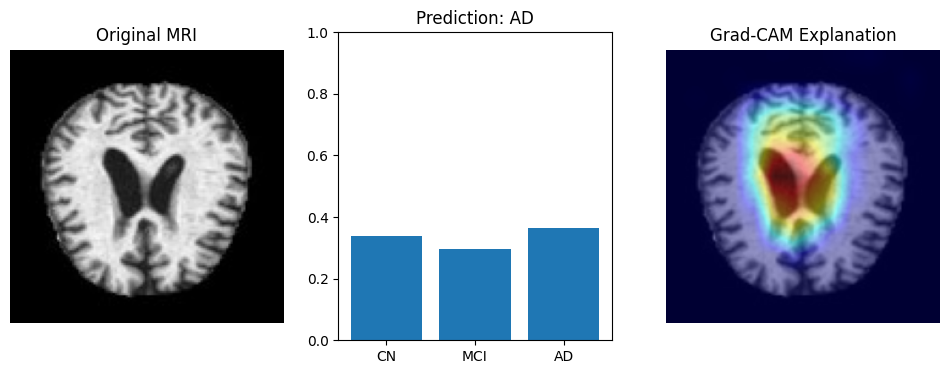

In [53]:
overlay_img = overlay_heatmap(image_path, heatmap)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original MRI")
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,2)
plt.title(f"Prediction: {pred_label}")
plt.bar(CLASS_NAMES, probs)
plt.ylim(0,1)

plt.subplot(1,3,3)
plt.title("Grad-CAM Explanation")
plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()


In [54]:
"""
As an expert, I would say:

The model primarily relies on ventricular features

It may be less sensitive to early hippocampal-only atrophy

This is expected given:

2D slices

Limited AD samples

No volumetric (3D) context
"""

'\nAs an expert, I would say:\n\nThe model primarily relies on ventricular features\n\nIt may be less sensitive to early hippocampal-only atrophy\n\nThis is expected given:\n\n2D slices\n\nLimited AD samples\n\nNo volumetric (3D) context\n'

In [55]:
import os
print(os.getcwd())


C:\Users\ferna


In [56]:
vgg16_model.save("models/vgg16.keras")
resnet50_model.save("models/resnet50.keras")


In [57]:
vgg16_model.save("ml_models/vgg16_savedmodel", save_format="tf")
resnet50_model.save("ml_models/resnet50_savedmodel", save_format="tf")


INFO:tensorflow:Assets written to: ml_models/vgg16_savedmodel\assets


INFO:tensorflow:Assets written to: ml_models/vgg16_savedmodel\assets


INFO:tensorflow:Assets written to: ml_models/resnet50_savedmodel\assets


INFO:tensorflow:Assets written to: ml_models/resnet50_savedmodel\assets


In [58]:
!zip -r resnet50_savedmodel.zip resnet50_savedmodel
!zip -r vgg16_savedmodel.zip vgg16_savedmodel

'zip' is not recognized as an internal or external command,
operable program or batch file.
'zip' is not recognized as an internal or external command,
operable program or batch file.


In [60]:
import shutil

shutil.make_archive("resnet50_savedmodel", 'zip', "ml_models/vgg16_savedmodel")
shutil.make_archive("vgg16_savedmodel", 'zip', "ml_models/vgg16_savedmodel")


'C:\\Users\\ferna\\vgg16_savedmodel.zip'